In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGES_PATH = 'data/images/'

In [230]:
image = io.imread('../' + IMAGES_PATH + 'barcode-00-01.jpg')

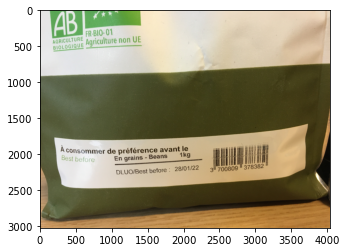

In [231]:
plt.imshow(image)

In [232]:
image = np.array(image).mean(axis=2).astype(np.uint8)
image.shape[1] / 16

252.0

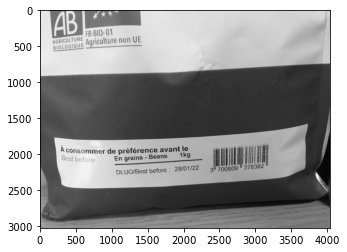

In [233]:
plt.imshow(image, cmap='gray')

In [234]:
tiles = []
n_cols = len(image[0])
n_rows = len(image)

for i in range(0, n_rows, 16):
    for j in range(0, n_cols, 16):
        tiles.append(image[i:i+16, j:j+16])

In [235]:
index_table = [(0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0), (0, 0), (0, 1)]
padding_row = np.zeros(18).astype(np.uint8).tolist()

In [236]:
def compute_lbp_value(lbp_window):
    lbp_value = 0
    pixel_value = lbp_window[1][1]
    for i in range(8):
        row_index, col_index = index_table[i]
        lbp_value += (lbp_window[row_index][col_index] >= pixel_value) ** i
        
    return lbp_value

In [237]:
def pad_tile(tile):
    tileList = tile.tolist()
    
    for i in range(16):
        tileList[i].insert(0, 0)
        tileList[i].append(0)
    tileList.insert(0, padding_row)
    tileList.append(padding_row)    
    return np.array(tileList)

In [238]:
tileTest = pad_tile(tiles[0])

In [239]:
print(tileTest)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 225 226 228 229 229 228 227 226 229 230 229 228 227 227 228 229   0]
 [  0 225 226 227 228 228 228 228 227 229 230 229 228 227 227 228 229   0]
 [  0 225 226 226 227 227 228 228 228 228 229 230 229 228 228 228 229   0]
 [  0 227 227 227 227 227 228 229 229 228 228 229 228 229 228 229 229   0]
 [  0 227 227 227 227 228 228 229 230 228 228 229 228 228 227 228 228   0]
 [  0 228 227 227 227 228 228 229 230 228 229 229 228 227 227 227 228   0]
 [  0 226 227 227 227 227 228 229 229 229 229 228 227 226 226 227 228   0]
 [  0 226 226 226 227 227 228 228 229 229 229 228 227 226 226 227 228   0]
 [  0 226 226 225 225 225 227 228 229 228 229 228 228 227 227 229 230   0]
 [  0 226 226 226 226 226 227 227 228 229 229 228 227 227 227 228 229   0]
 [  0 226 226 226 226 226 227 227 227 230 229 229 227 227 226 227 228   0]
 [  0 228 228 227 227 227 228 228 228 230 230 229 227 227 226 226 227   0]
 [  0 229 228 227 226 227

In [240]:
histo_list = []

for tile in tiles:
    padded_tile = pad_tile(tile)
    lbp_histo = [0 for i in range(256)]
    
    for i in range(1, 17):
        for j in range(1, 17):
            window = padded_tile[i-1:i+2, j-1:j+2]
            lbp_histo[compute_lbp_value(window)] += 1    
            
    histo_list.append(lbp_histo)
    
    

In [241]:
from sklearn.cluster import KMeans

In [242]:
print(len(histo_list) / len(tiles))

1.0


In [243]:
histo = np.array(histo_list)

In [244]:
histo.shape

(47628, 256)

In [259]:
n_cluster=16

In [260]:
kmeans = KMeans(n_clusters=n_cluster, random_state=128).fit(histo)

In [261]:
transformed = kmeans.predict(histo)

In [262]:
print(transformed.shape)

(47628,)


In [263]:
transformed_reshape = transformed.reshape(image.shape[0] // 16, image.shape[1] // 16)

In [264]:
transformed_reshape.shape

(189, 252)

In [265]:
print(transformed_reshape)

[[ 4  1  7 ...  8  3 11]
 [ 3  4  3 ...  8  6  1]
 [ 1  7  1 ...  5  3  1]
 ...
 [ 6 10  0 ...  5 15 15]
 [ 8  9  8 ...  6  5  5]
 [10 15  0 ... 11  6 11]]


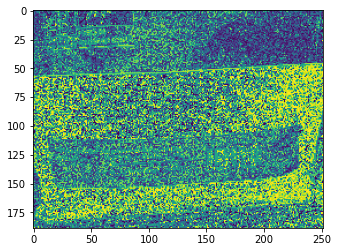

In [266]:
plt.imshow(transformed_reshape)

In [267]:
import matplotlib.cm as cm


In [268]:
def random_lut(n_values):
    '''Build a random LUT for `n_values` elements (sequential integers).'''
    samples = np.linspace(0, 1, n_values)  # take n_values values between 0 and 1 (evenly spaced)
    rng = np.random.default_rng(3)  # get a RNG with a specific seed
    samples = rng.permutation(samples)  # shuffle our values
    colors = cm.hsv(samples, alpha=None, bytes=True)  # get corresponding colors from the HSV color map
    return colors[...,:3]  # remove alpha channel and return

In [269]:
lut = random_lut(n_cluster)

In [270]:
recolored = lut[transformed_reshape]
recolored.shape

(189, 252, 3)

In [271]:
def show_image_seg(img, recolored, n_clusters):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original image")
    plt.subplot(1,2,2)
    plt.imshow(recolored)
    plt.title(f"Segmented areas (with spatial info), {n_clusters} clusters")

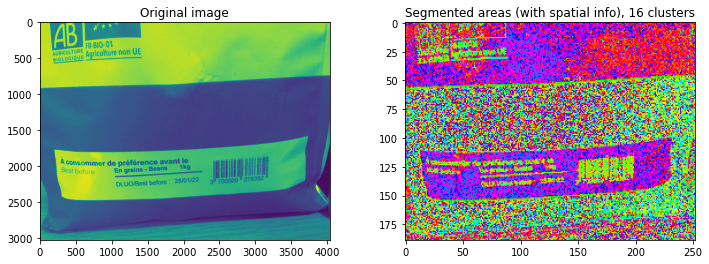

In [272]:
show_image_seg(image, recolored, n_cluster)

In [273]:
kmeans.cluster_centers_.shape

(16, 256)

In [274]:
transformed.shape

(47628,)

In [277]:
from sklearn.neighbors import NearestCentroid
search_engine = NearestCentroid();
# Fit sur ton tableau d'histogramme
search_engine.fit(histo, transformed);
#distance, results = search_engine.kneighbors(histo, n_neighbors=16);

neighbor_prediction = search_engine.predict(histo)

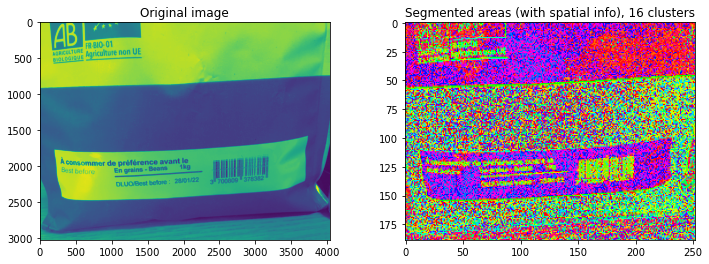

In [278]:
neighbor_recolored = lut[neighbor_prediction.reshape(image.shape[0] // 16, image.shape[1] // 16)]


show_image_seg(image, neighbor_recolored, n_cluster)

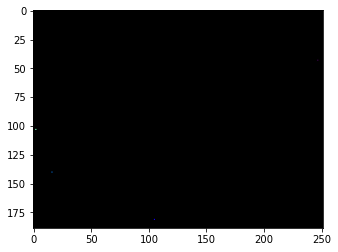

In [218]:
diff = neighbor_recolored - recolored
plt.imshow(diff, cmap='gray')

In [219]:
print(results.shape)

(47628, 16)


In [220]:
results

array([[    0, 30699, 10350, ..., 28237, 10232,  2650],
       [    1, 13442,   539, ..., 30119, 29539, 12112],
       [    2, 10586, 36965, ...,  2619,  2477, 10006],
       ...,
       [47625, 41200, 19471, ..., 21006, 43668, 24658],
       [47626, 43685, 42745, ..., 39052,  7072, 16257],
       [47627, 41743, 46795, ..., 25345,  1727, 46091]])

In [221]:
distance

array([[ 0.        ,  3.74165739,  4.        , ...,  6.32455532,
         6.32455532,  6.32455532],
       [ 0.        ,  7.07106781,  7.34846923, ...,  8.24621125,
         8.24621125,  8.36660027],
       [ 0.        ,  8.24621125,  8.94427191, ..., 11.3137085 ,
        11.40175425, 11.48912529],
       ...,
       [ 0.        ,  3.74165739,  4.        , ...,  5.47722558,
         5.47722558,  5.47722558],
       [ 0.        ,  5.83095189,  6.63324958, ...,  9.59166305,
         9.59166305,  9.69535971],
       [ 0.        ,  3.74165739,  4.        , ...,  5.47722558,
         5.47722558,  5.65685425]])